In [35]:
import os
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import time
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
import pickle
import joblib

In [36]:
train = pd.read_csv("/kaggle/input/samplednoinfnonnorm/RandomSamplingSMOTE_train_Sampled_NOINF_nonnorm.csv")
test = pd.read_csv("/kaggle/input/noinfnonnormtestt/X_test.csv")

In [37]:
X_fe_train = train.copy()
X_fe_train.head()

,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,0,1,2,3,4,5
0,6,117986095,11,9,875,355,517,0,79.545455,154.043087,156,0,39.444444,50.953683,10.424957,0.169512,6.209794e+06,1.847123e+07,58889657,39,117986095,1.179861e+07,2.470012e+07,58889657,270,117830343,1.472879e+07,2.717155e+07,59045336,101,0,0,232,192,0.093231,0.076280,0,517,58.571429,116.108816,13481.257143,0,0,0,1,0,0,0,0,0,61.500000,79.545455,39.444444,11,875,9,355,8192,176,6,20,289957.000000,189894.940301,424233,155681,5.862518e+07,374022.010588,58889657,58360710,1.0,0.0,0.0,0.0,0.0,0.0
1,6,86160336,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.023213,8.616034e+07,0.000000e+00,86160336,86160336,86160336,8.616034e+07,0.000000e+00,86160336,86160336,0,0.000000e+00,0.000000e+00,0,0,0,0,40,0,0.023213,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,62559,-1,0,20,0.000000,0.000000,0,0,8.616034e+07,0.000000,86160336,86160336,1.0,0.0,0.0,0.0,0.0,0.0
2,6,3769550,14,8,1439,1731,725,0,102.785714,191.197111,1179,0,216.375000,405.464791,840.949185,5.836240,1.795024e+05,2.442908e+05,953172,92,3769550,2.899654e+05,3.345512e+05,1233060,12264,3695062,5.278660e+05,3.148140e+05,953172,159199,0,0,292,172,3.713971,2.122269,0,1179,137.826087,278.925642,77799.513834,0,0,1,1,0,0,0,1,0,144.090909,102.785714,216.375000,14,1439,8,1731,8192,62646,7,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,1.0,0.0,0.0,0.0,0.0,0.0
3,6,61337501,21,19,2727,9591,724,0,129.857143,242.631054,1460,0,504.789474,584.643061,200.823310,0.652130,1.572756e+06,3.637245e+06,10003474,10,61337501,3.066875e+06,4.658209e+06,10015345,1309,61325295,3.406961e+06,4.810119e+06,10015500,18,0,0,432,384,0.342368,0.309762,0,1460,300.439024,469.698842,220617.002439,0,0,0,1,0,0,0,0,0,307.950000,129.857143,504.789474,21,2727,19,9591,8192,35476,12,20,195588.333333,449991.678643,1114130,11845,9.990232e+06,32318.260496,10003474,9924263,1.0,0.0,0.0,0.0,0.0,0.0
4,17,2573,1,1,30,207,30,30,30.000000,0.000000,207,207,207.000000,0.000000,92110.376992,777.302759,2.573000e+03,0.000000e+00,2573,2573,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,8,8,388.651380,388.651380,30,207,89.000000,102.190998,10443.000000,0,0,0,0,0,0,0,0,1,133.500000,30.000000,207.000000,1,30,1,207,-1,-1,0,8,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
X_fe_test = test.copy()
X_fe_test.head()

,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,0,1,2,3,4,5
0,6,2471708,8,8,1148,1581,677,0,143.500000,228.129662,1173,0,197.625,406.121705,1104.094820,6.473257,164780.5333,247260.950400,953116,0,2471708,353101.1429,407845.290600,1254799,0,2232024,318860.5714,295880.8080,953116,2329,0,0,168,168,3.236628,3.236628,0,1173,160.529412,312.044091,97371.514710,0,0,0,1,0,0,0,0,1,170.562500,143.500000,197.625,8,1148,8,1581,8192,62852,5,20,0.0,0.0,0,0,0.0,0.0,0,0,1,0,0,0,0,0
1,6,816,3,0,77,0,46,0,25.666667,23.459184,0,0,0.000,0.000000,94362.745100,3676.470588,408.0000,551.543289,798,18,816,408.0000,551.543289,798,18,0,0.0000,0.0000,0,0,1,0,60,0,3676.470588,0.000000,0,46,30.750000,21.685248,470.250000,0,1,0,0,1,0,0,0,0,41.000000,25.666667,0.000,3,77,0,0,253,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,1,0,0,0,0,0
2,6,2495557,9,8,1789,1581,661,0,198.777778,270.943619,1173,0,197.625,406.121705,1350.399931,6.812106,155972.3125,171182.714900,534803,4,2495557,311944.6250,236298.330300,803597,4,2226710,318101.4286,115800.7250,534803,239472,0,0,192,184,3.606409,3.205697,0,1173,187.222222,323.487168,104643.947700,0,0,1,1,0,0,0,1,0,198.235294,198.777778,197.625,9,1789,8,1581,8192,62872,6,20,0.0,0.0,0,0,0.0,0.0,0,0,1,0,0,0,0,0
3,6,116,2,1,38,0,38,0,19.000000,26.870058,0,0,0.000,0.000000,327586.206900,25862.068970,58.0000,50.911688,94,22,116,116.0000,0.000000,116,116,0,0.0000,0.0000,0,0,1,0,40,20,17241.379310,8620.689655,0,38,19.000000,21.939310,481.333333,0,1,0,0,1,0,0,0,0,25.333333,19.000000,0.000,2,38,1,0,176,0,0,20,0.0,0.0,0,0,0.0,0.0,0,0,1,0,0,0,0,0
4,6,3958451,14,8,1441,1731,725,0,102.928571,191.148941,1179,0,216.375,405.464791,801.323548,5.557730,188497.6667,264910.424100,953091,61,3958451,304496.2308,348814.473800,1209621,28238,3926456,560922.2857,355275.4029,1044843,107526,0,0,292,172,3.536737,2.020993,0,1179,137.913043,278.894720,77782.264820,0,0,1,1,0,0,0,1,0,144.181818,102.928571,216.375,14,1441,8,1731,8192,62644,7,20,0.0,0.0,0,0,0.0,0.0,0,0,1,0,0,0,0,0


In [39]:
last_6_columns = X_fe_train.iloc[:, -6:]
Y_fe_train = pd.DataFrame(last_6_columns)
Y_fe_train.head()

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In [40]:
Y_fe_train.dtypes

0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
dtype: object

In [41]:
last_6_columns_test = X_fe_test.iloc[:, -6:]
Y_fe_test = pd.DataFrame(last_6_columns_test)
Y_fe_test.head()

,0,1,2,3,4,5
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [42]:
X_fe_train = X_fe_train.drop(X_fe_train.columns[-6:], axis=1)
X_fe_train.head()

,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,6,117986095,11,9,875,355,517,0,79.545455,154.043087,156,0,39.444444,50.953683,10.424957,0.169512,6.209794e+06,1.847123e+07,58889657,39,117986095,1.179861e+07,2.470012e+07,58889657,270,117830343,1.472879e+07,2.717155e+07,59045336,101,0,0,232,192,0.093231,0.076280,0,517,58.571429,116.108816,13481.257143,0,0,0,1,0,0,0,0,0,61.500000,79.545455,39.444444,11,875,9,355,8192,176,6,20,289957.000000,189894.940301,424233,155681,5.862518e+07,374022.010588,58889657,58360710
1,6,86160336,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.023213,8.616034e+07,0.000000e+00,86160336,86160336,86160336,8.616034e+07,0.000000e+00,86160336,86160336,0,0.000000e+00,0.000000e+00,0,0,0,0,40,0,0.023213,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,62559,-1,0,20,0.000000,0.000000,0,0,8.616034e+07,0.000000,86160336,86160336
2,6,3769550,14,8,1439,1731,725,0,102.785714,191.197111,1179,0,216.375000,405.464791,840.949185,5.836240,1.795024e+05,2.442908e+05,953172,92,3769550,2.899654e+05,3.345512e+05,1233060,12264,3695062,5.278660e+05,3.148140e+05,953172,159199,0,0,292,172,3.713971,2.122269,0,1179,137.826087,278.925642,77799.513834,0,0,1,1,0,0,0,1,0,144.090909,102.785714,216.375000,14,1439,8,1731,8192,62646,7,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0
3,6,61337501,21,19,2727,9591,724,0,129.857143,242.631054,1460,0,504.789474,584.643061,200.823310,0.652130,1.572756e+06,3.637245e+06,10003474,10,61337501,3.066875e+06,4.658209e+06,10015345,1309,61325295,3.406961e+06,4.810119e+06,10015500,18,0,0,432,384,0.342368,0.309762,0,1460,300.439024,469.698842,220617.002439,0,0,0,1,0,0,0,0,0,307.950000,129.857143,504.789474,21,2727,19,9591,8192,35476,12,20,195588.333333,449991.678643,1114130,11845,9.990232e+06,32318.260496,10003474,9924263
4,17,2573,1,1,30,207,30,30,30.000000,0.000000,207,207,207.000000,0.000000,92110.376992,777.302759,2.573000e+03,0.000000e+00,2573,2573,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,8,8,388.651380,388.651380,30,207,89.000000,102.190998,10443.000000,0,0,0,0,0,0,0,0,1,133.500000,30.000000,207.000000,1,30,1,207,-1,-1,0,8,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0


In [43]:
X_fe_test = X_fe_test.drop(X_fe_test.columns[-6:], axis=1)
X_fe_test.head()

,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,6,2471708,8,8,1148,1581,677,0,143.500000,228.129662,1173,0,197.625,406.121705,1104.094820,6.473257,164780.5333,247260.950400,953116,0,2471708,353101.1429,407845.290600,1254799,0,2232024,318860.5714,295880.8080,953116,2329,0,0,168,168,3.236628,3.236628,0,1173,160.529412,312.044091,97371.514710,0,0,0,1,0,0,0,0,1,170.562500,143.500000,197.625,8,1148,8,1581,8192,62852,5,20,0.0,0.0,0,0,0.0,0.0,0,0
1,6,816,3,0,77,0,46,0,25.666667,23.459184,0,0,0.000,0.000000,94362.745100,3676.470588,408.0000,551.543289,798,18,816,408.0000,551.543289,798,18,0,0.0000,0.0000,0,0,1,0,60,0,3676.470588,0.000000,0,46,30.750000,21.685248,470.250000,0,1,0,0,1,0,0,0,0,41.000000,25.666667,0.000,3,77,0,0,253,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2,6,2495557,9,8,1789,1581,661,0,198.777778,270.943619,1173,0,197.625,406.121705,1350.399931,6.812106,155972.3125,171182.714900,534803,4,2495557,311944.6250,236298.330300,803597,4,2226710,318101.4286,115800.7250,534803,239472,0,0,192,184,3.606409,3.205697,0,1173,187.222222,323.487168,104643.947700,0,0,1,1,0,0,0,1,0,198.235294,198.777778,197.625,9,1789,8,1581,8192,62872,6,20,0.0,0.0,0,0,0.0,0.0,0,0
3,6,116,2,1,38,0,38,0,19.000000,26.870058,0,0,0.000,0.000000,327586.206900,25862.068970,58.0000,50.911688,94,22,116,116.0000,0.000000,116,116,0,0.0000,0.0000,0,0,1,0,40,20,17241.379310,8620.689655,0,38,19.000000,21.939310,481.333333,0,1,0,0,1,0,0,0,0,25.333333,19.000000,0.000,2,38,1,0,176,0,0,20,0.0,0.0,0,0,0.0,0.0,0,0
4,6,3958451,14,8,1441,1731,725,0,102.928571,191.148941,1179,0,216.375,405.464791,801.323548,5.557730,188497.6667,264910.424100,953091,61,3958451,304496.2308,348814.473800,1209621,28238,3926456,560922.2857,355275.4029,1044843,107526,0,0,292,172,3.536737,2.020993,0,1179,137.913043,278.894720,77782.264820,0,0,1,1,0,0,0,1,0,144.181818,102.928571,216.375,14,1441,8,1731,8192,62644,7,20,0.0,0.0,0,0,0.0,0.0,0,0


In [44]:
X_fe_test.dtypes

Protocol               int64
Flow Duration          int64
Tot Fwd Pkts           int64
Tot Bwd Pkts           int64
TotLen Fwd Pkts        int64
TotLen Bwd Pkts        int64
Fwd Pkt Len Max        int64
Fwd Pkt Len Min        int64
Fwd Pkt Len Mean     float64
Fwd Pkt Len Std      float64
Bwd Pkt Len Max        int64
Bwd Pkt Len Min        int64
Bwd Pkt Len Mean     float64
Bwd Pkt Len Std      float64
Flow Byts/s          float64
Flow Pkts/s          float64
Flow IAT Mean        float64
Flow IAT Std         float64
Flow IAT Max           int64
Flow IAT Min           int64
Fwd IAT Tot            int64
Fwd IAT Mean         float64
Fwd IAT Std          float64
Fwd IAT Max            int64
Fwd IAT Min            int64
Bwd IAT Tot            int64
Bwd IAT Mean         float64
Bwd IAT Std          float64
Bwd IAT Max            int64
Bwd IAT Min            int64
Fwd PSH Flags          int64
Fwd URG Flags          int64
Fwd Header Len         int64
Bwd Header Len         int64
Fwd Pkts/s    

# Using RFE and RF
* Decision Tree
* AdaBoost
* RF 
* XGBoost 
* CatBoost 

[www.evidentlyai.com/classification-metrics/multi-class-metrics](https://)

In [46]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1))
sel.fit(X_fe_train, Y_fe_train)
sel.get_support()

X_fe_train.columns

features = X_fe_train.columns[sel.get_support()]
print(features)
print(len(features))

np.mean(sel.estimator_.feature_importances_)

X_train_rfe = sel.transform(X_fe_train)
X_test_rfe = sel.transform(X_fe_test)

Index(['Flow Duration', 'Tot Fwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Max', 'ECE Flag Cnt', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts',
       'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min'],
      dtype='object')
32


In [47]:
Y_fe_train_1d = np.argmax(Y_fe_train.values, axis=1)
training_times = []

random_state = 42

unique_classes = np.unique(Y_fe_train_1d)
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
Y_fe_train_1d_mapped = np.vectorize(class_mapping.get)(Y_fe_train_1d)

clf_rfe_keys = ["XGBoost"]
clf_rfe_values = [XGBClassifier(random_state=random_state)]

clfs_rfe = dict(zip(clf_rfe_keys, clf_rfe_values))

print("Model training using feature-selected data: started!")
for clf_rfe_name, clf_rfe in clfs_rfe.items():
    start_time = time.time()
    clf_rfe.fit(X_train_rfe, Y_fe_train_1d_mapped)
    filename = 'xgb_network_model.pkl'
    pickle.dump(clf_rfe, open(filename, 'wb'))
    clfs_rfe[clf_rfe_name] = clf_rfe
    end_time = time.time()
    training_time = end_time - start_time
    print(clf_rfe_name, "training: done! in", training_time  )
print("Model training using feature-selected data: done!")

Model training using feature-selected data: started!
XGBoost training: done! in 1520.133514881134
Model training using feature-selected data: done!


In [48]:
Y_fe_test_1d = np.argmax(Y_fe_test.values, axis=1)

acc_rfe = []
f1_rfe = []
precision_rfe = []
recall_rfe = []

max_f1 = {"score": 0, "model": ""}
max_precision = {"score": 0, "model": ""}
max_recall = {"score": 0, "model": ""}

for clf_rfe_name, clf_rfe in clfs_rfe.items():
    y_rfe_pred = clf_rfe.predict(X_test_rfe)
    
    f1 = f1_score(Y_fe_test_1d, y_rfe_pred, average='macro')
    precision = precision_score(Y_fe_test_1d, y_rfe_pred, average='macro')
    recall = recall_score(Y_fe_test_1d, y_rfe_pred, average='macro')
    acc_rfe.append(accuracy_score(Y_fe_test_1d, y_rfe_pred))
    
    f1_rfe.append(f1)
    precision_rfe.append(precision)
    recall_rfe.append(recall)
    
    # Update maximum metrics and corresponding model names
    if f1 > max_f1["score"]:
        max_f1 = {"score": f1, "model": clf_rfe_name}
    if precision > max_precision["score"]:
        max_precision = {"score": precision, "model": clf_rfe_name}
    if recall > max_recall["score"]:
        max_recall = {"score": recall, "model": clf_rfe_name}    
    
    
acc_all = pd.DataFrame({"Feature-selected dataset": acc_rfe},index=clf_rfe_keys)

metrics_all = pd.DataFrame({
    "Feature-selected dataset - Accuracy": acc_rfe,
    "Feature-selected dataset - F1 Score": f1_rfe,
    "Feature-selected dataset - Precision": precision_rfe,
    "Feature-selected dataset - Recall": recall_rfe,
}, index=clf_rfe_keys)

metrics_all

,Feature-selected dataset - Accuracy,Feature-selected dataset - F1 Score,Feature-selected dataset - Precision,Feature-selected dataset - Recall
XGBoost,0.999032,0.761401,0.716411,0.894504


In [49]:
max_acc_rfe = acc_all["Feature-selected dataset"].max()
best_model_rfe = acc_all[acc_all["Feature-selected dataset"] == max_acc_rfe].index[0]
print("Max Accuracy:", max_acc_rfe, "achieved by:", best_model_rfe)
print("Max F1 score: ", max_f1["score"], " achieved by ", max_f1["model"])
print("Max Precision: ", max_precision["score"], " achieved by ", max_precision["model"])
print("Max Recall: ", max_recall["score"], " achieved by ", max_recall["model"])

Max Accuracy: 0.9990320876891327 achieved by: XGBoost
Max F1 score:  0.7614009995733056  achieved by  XGBoost
Max Precision:  0.7164107145946397  achieved by  XGBoost
Max Recall:  0.8945035336964585  achieved by  XGBoost


In [60]:
def calculate_accuracy_per_class(y_true, y_pred):
    classes = set(y_true)
    accuracy_per_class = {}
    for c in classes:
        samples = [y for y, pred in zip(y_true, y_pred) if y == c]
        correctly_classified = [y for y, pred in zip(y_true, y_pred) if y == c and y == pred]
        accuracy_per_class[c] = len(correctly_classified) / len(samples) if samples else 0
    return accuracy_per_class

acc_df = pd.DataFrame()

Y_fe_test_1d = np.argmax(Y_fe_test.values, axis=1)
for clf_rfe_name, clf_rfe in clfs_rfe.items():
    y_rfe_pred = clf_rfe.predict(X_test_rfe)
    acc_per_class = calculate_accuracy_per_class(Y_fe_test_1d, y_rfe_pred)
    acc_df = pd.concat([acc_df, pd.DataFrame.from_dict(acc_per_class, orient='index')], ignore_index=True)

acc_df.columns = ['Accuracy']
acc_df

,Accuracy
0,0.999053
1,0.846847
2,0.956522
3,0.800000
4,0.764706
5,0.999894


In [ ]:
def calculate_metrics_per_class(y_true, y_pred):
    classes = set(y_true)
    metrics_per_class = {}
    for c in classes:
        samples = [y for y, pred in zip(y_true, y_pred) if y == c]
        true_positives = [y for y, pred in zip(y_true, y_pred) if y == c and y == pred]
        false_positives = [y for y, pred in zip(y_true, y_pred) if y != c and pred == c]
        false_negatives = [y for y, pred in zip(y_true, y_pred) if y == c and y != pred]
        precision = len(true_positives) / (len(true_positives) + len(false_positives)) if samples else 0
        recall = len(true_positives) / (len(true_positives) + len(false_negatives)) if samples else 0
        f1 = 2 * precision * recall / (precision + recall) if samples else 0
        metrics_per_class[c] = {'precision': precision, 'recall': recall, 'f1_score': f1}
    return metrics_per_class

Y_fe_test_1d = np.argmax(Y_fe_test.values, axis=1)
metrics_df = pd.DataFrame()

for clf_rfe_name, clf_rfe in clfs_rfe.items():
    y_rfe_pred = clf_rfe.predict(X_test_rfe)
    metrics_per_class = calculate_metrics_per_class(Y_fe_test_1d, y_rfe_pred)
    metrics_df = pd.concat([metrics_df, pd.DataFrame.from_dict(metrics_per_class, orient='index')], ignore_index=True)
    
metrics_df.columns = ['Precision', 'Recall', 'F1 Score']
metrics_df

,Precision,Recall,F1 Score
0,0.999976,0.999053,0.999514
1,0.199575,0.846847,0.323024
2,0.916667,0.956522,0.936170
3,0.800000,0.800000,0.800000
4,0.382353,0.764706,0.509804
5,0.999894,0.999894,0.999894


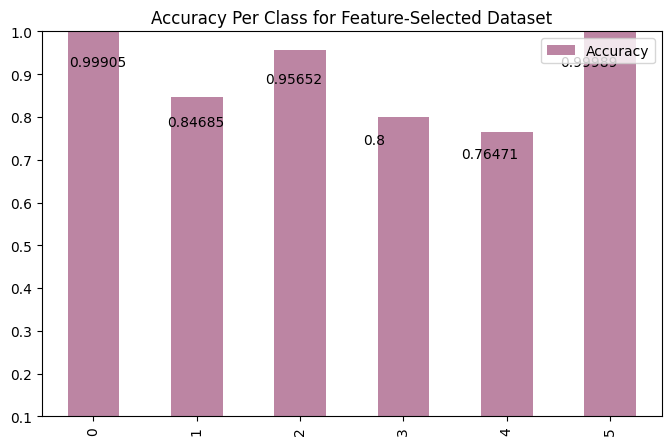

In [67]:
colors = ['#bc85a3']
ax = acc_df.plot.bar(color=colors, figsize=(8, 5))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(5)), (p.get_x()*0.95, p.get_height()*0.92))
plt.ylim((0.10, 1.00))
plt.title("Accuracy Per Class for Feature-Selected Dataset")
plt.show()

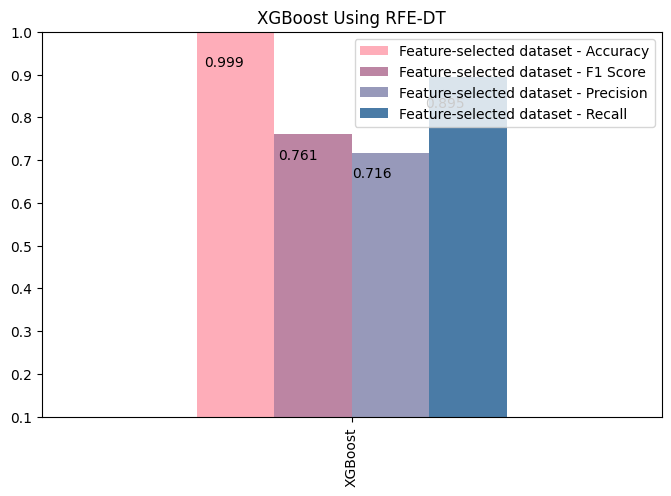

In [51]:
colors = ['#feadb9','#bc85a3','#9799ba','#4a7ba6']
ax = metrics_all.plot.bar(color = colors, figsize=(8, 5))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.95, p.get_height()*0.92))
plt.ylim((0.10, 1.00))
plt.title("XGBoost Using RFE-DT")
plt.show()

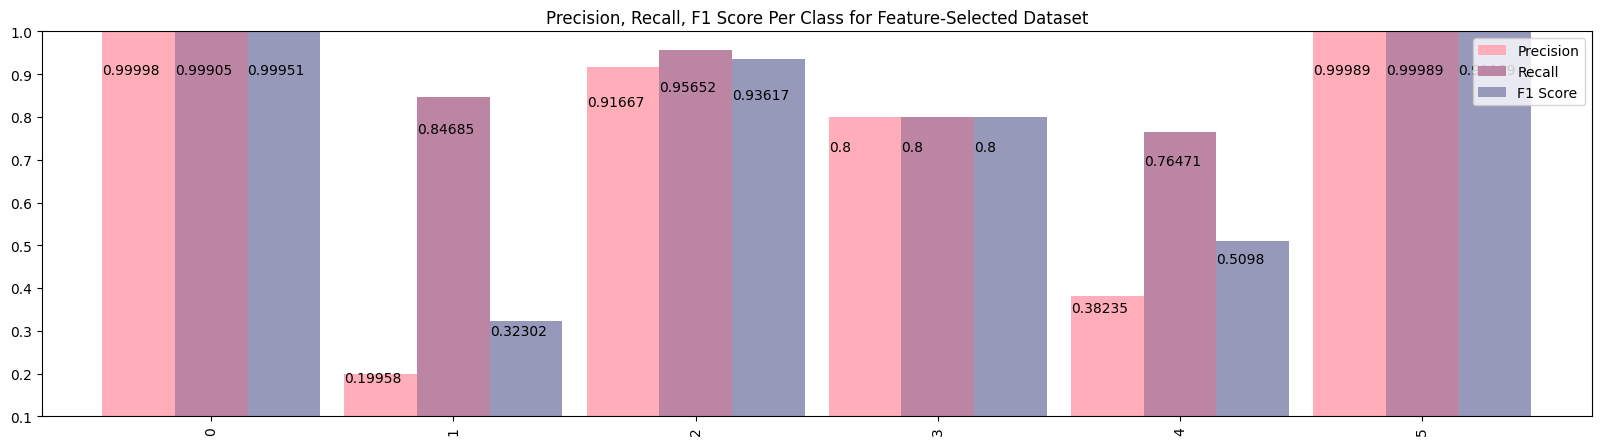

In [64]:
colors = ['#feadb9','#bc85a3','#9799ba']
ax = metrics_df.plot.bar(color=colors, width=0.9, figsize=(20, 5))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(5)), (p.get_x(), p.get_height()*0.90))
plt.ylim((0.10, 1.0))
plt.title("Precision, Recall, F1 Score Per Class for Feature-Selected Dataset")
plt.show()